# ***4.* Recurrent network of nonlinear springs and masses**

## *4.1* **Implementation of the recurrent networks of non-linear springs and masses**

### *4.1.1* Constructing mass-spring networks

Importing Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Delaunay
import random
import math
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
import scipy.integrate as spi
from IPython.display import clear_output

Having a dictionary to contain all the inital setups

In [3]:
init_dict = dict()

Setting up

1.   number of nodes (N)
2.   limits of x and y coordinates



In [4]:
init_dict['nodes'] = 10 #Number of masses
inputs = 1 #numbe of inputs
percentage = inputs/init_dict['nodes'] #percentage to set for inputs
init_dict['x_lim'] = [0,10]
init_dict['y_lim'] = [0,10]

In [5]:
rk_steps = 100 #number of rk_steps : h = time_step/rk_steps

ADDING noise , and setting it to be 0

In [6]:
init_dict['pos_noise'] = 0
init_dict['dist_nosie'] = 0

getting random nodes spread out positions

In [7]:
init_dict['positions'] = np.zeros((init_dict['nodes'],4))
init_dict['positions'][:,0] = np.random.uniform(init_dict['x_lim'][0], init_dict['x_lim'][1], init_dict['nodes'])
init_dict['positions'][:,1] = np.random.uniform(init_dict['y_lim'][0], init_dict['y_lim'][1], init_dict['nodes'])
init_dict['fixed_positions'] = True

In [8]:
init_dict['positions']

array([[1.64057602, 7.82511936, 0.        , 0.        ],
       [5.7688529 , 9.89813879, 0.        , 0.        ],
       [7.72807312, 3.32195491, 0.        , 0.        ],
       [7.28848311, 1.39397376, 0.        , 0.        ],
       [3.2481578 , 2.33557449, 0.        , 0.        ],
       [7.71703185, 1.1188429 , 0.        , 0.        ],
       [2.62223651, 2.08853642, 0.        , 0.        ],
       [4.56441765, 9.18406687, 0.        , 0.        ],
       [3.18033113, 7.82469007, 0.        , 0.        ],
       [6.17102473, 2.61347535, 0.        , 0.        ]])

Setting up the spring parameter ranges

In [9]:
init_dict['k_range'] = np.array([[1, 200], [1, 10]])
init_dict['d_range'] = np.array([[1, 200], [1, 10]])

Setting up weight parameters

In [10]:
init_dict['w_out_range'] = [-1, 1]
init_dict['w_feedback_range'] = [-1, 1]
init_dict['w_input_range'] = [-1 ,1]

Feedback parameters

In [11]:
init_dict['fb_conn'] = 0 #Feedback connectivity

Number of inputs and outputs

In [12]:
init_dict['nInput'] = 1
init_dict['input_percentage'] = percentage #percentage of input connectivity nodes
init_dict['nOutput'] = 1
init_dict['out_conn'] = 1 #1 = 100% of nodes

Initializing time_steps and steps to show (show_steps)

In [13]:
init_dict['time_step'] = 0.001 # time_step = 1 ms = 0.001 s
init_dict['show_steps'] = 1000 # to show the simulation progress at every 1000 steps

Also defining the readout type we want

In [14]:
init_dict['readout_type'] = 'POSITIONS'

Also

Printing the initial dictionary we defined

In [15]:
init_dict

{'nodes': 10,
 'x_lim': [0, 10],
 'y_lim': [0, 10],
 'pos_noise': 0,
 'dist_nosie': 0,
 'positions': array([[1.64057602, 7.82511936, 0.        , 0.        ],
        [5.7688529 , 9.89813879, 0.        , 0.        ],
        [7.72807312, 3.32195491, 0.        , 0.        ],
        [7.28848311, 1.39397376, 0.        , 0.        ],
        [3.2481578 , 2.33557449, 0.        , 0.        ],
        [7.71703185, 1.1188429 , 0.        , 0.        ],
        [2.62223651, 2.08853642, 0.        , 0.        ],
        [4.56441765, 9.18406687, 0.        , 0.        ],
        [3.18033113, 7.82469007, 0.        , 0.        ],
        [6.17102473, 2.61347535, 0.        , 0.        ]]),
 'fixed_positions': True,
 'k_range': array([[  1, 200],
        [  1,  10]]),
 'd_range': array([[  1, 200],
        [  1,  10]]),
 'w_out_range': [-1, 1],
 'w_feedback_range': [-1, 1],
 'w_input_range': [-1, 1],
 'fb_conn': 0,
 'nInput': 1,
 'input_percentage': 0.1,
 'nOutput': 1,
 'out_conn': 1,
 'time_step': 0.00

Now since we have initialized the parameters, we will build up the net of spring_mass system now

So, first we define a dictionary called net, which will have our initialized data and also the informations about the points.

In [16]:
net = dict()

net['init_data'] = init_dict
num = init_dict['nodes']

net['P'] = dict() #the dictionary for points informations

Random initialization of point states and forces

In [17]:
if init_dict['fixed_positions'] == True:
  net['P']['states'] = init_dict['positions']
else:
      net['P']['states'] = np.column_stack([
        np.random.uniform(init_dict['x_lim'][0], init_dict['x_lim'][1], num),
        np.random.uniform(init_dict['y_lim'][0], init_dict['y_lim'][1], num),
        np.zeros(num),
        np.zeros(num)
    ])

net['P']['force'] = np.zeros((num, 2)) #The forces with Fx and Fy
net['P']['fixed'] = np.zeros(num) # 0 if the nodes are not fixed, and we update it to 1 if they are fixed

Saving initial position and velocities of P

In [18]:
net['init_data']['P'] = net['P']

In [19]:
net['pos_noise'] = init_dict['pos_noise']
net['dist_noise'] = init_dict['dist_nosie']

Fixing the leftmost and rightmost point such that our net remains stable

In [20]:
#Finding the rightmost (argmax) and leftmost (argmin) points

min_idx = np.argmin(net['P']['states'][:, 0])
max_idx = np.argmax(net['P']['states'][:, 0])

#Putting 1 at the points position, representing that it is fixed

net['P']['fixed'][min_idx] = 1
net['P']['fixed'][max_idx] = 1

Since, we have the points (nodes) now, so, we have to do **Delaunay triangulation** such that no two spring connections should overlap each other.

In [21]:
tri = Delaunay(net['P']['states'][:, :2])
net['init_data']['tri'] = tri

Sorting the triangulation is used to ensure that the triangles are processed in a specific order. Specifically, the np.sort function sorts the simplices (i.e., the triangles) in the triangulation along the second dimension, which corresponds to the nodes of each simplex.
This is necessary to ensure that the connections between adjacent triangles are processed correctly in the subsequent code.

In [22]:
tri_s = np.sort(tri.simplices, axis=1)  #sorting the triangulation (Delaunay  matrix)

Making an array to put which node is connected to which node

In [23]:
R = np.zeros((net['init_data']['nodes'], net['init_data']['nodes'])) #shape  = (nodes,nodes), for N = 10 shape = (10,10)

The Delaunay triangulation returns the triangles that are not overlapping

In [24]:
for i in range(tri.simplices.shape[0]):

    # Putting connection between element 1 --> 2
    from_ = tri_s[i, 0]
    to_ = tri_s[i, 1]
    R[from_, to_] = 1

    # Putting connection between element 2 --> 3
    from_ = tri_s[i, 1]
    to_ = tri_s[i, 2]
    R[from_, to_] = 1

    # Putting connection between element 1 --> 3
    from_ = tri_s[i, 0]
    to_ = tri_s[i, 2]
    R[from_, to_] = 1

So, now we can check the connections.

In [25]:
for i in range(R.shape[0]):
  connections = []
  for j in range(R.shape[1]):
    if R[i][j] == 1:
      connections.append(j)
  print(f'Node {i} is connected with node {connections}')

Node 0 is connected with node [1, 4, 6, 7, 8]
Node 1 is connected with node [2, 7]
Node 2 is connected with node [3, 5, 7, 8, 9]
Node 3 is connected with node [4, 5, 6, 9]
Node 4 is connected with node [6, 8, 9]
Node 5 is connected with node [6]
Node 6 is connected with node []
Node 7 is connected with node [8]
Node 8 is connected with node [9]
Node 9 is connected with node []


*It only shows unique connections*

Now, we will choose the spring constants and damping constant from an exponential distribution, so we need to define a function that does that

In [26]:
def random_exp(range_,a=None):
  #a : int or array-like, optional :The size of the output array. If not provided, returns a single random value.
  #range_ = np.array(range_)
  #lo, up = range_[0], range_[1]
  #if a is None:
  #  n = (up - lo)*random.random() + lo
  #else:
  #      if range_.shape[0] == 2:
  #          lo, up = np.log10(lo), np.log10(up)
  #      n = np.power(10, (up-lo)*np.random.sample(size=a) + lo)
  n = np.random.uniform(range_[0],range_[1],size=a)
  return n

Setting up weights (values)

In [27]:
w_num = int(np.sum(R))

In [28]:
net['W'] = dict()
net['W']['from'] = np.zeros(w_num)
net['W']['to'] = np.zeros(w_num)

In [29]:
net['W']['k1'] = random_exp([init_dict['k_range'][0, 0], init_dict['k_range'][0, 1]], w_num)
net['W']['k3'] = random_exp([init_dict['k_range'][1, 0], init_dict['k_range'][1, 1]], w_num)
net['W']['d1'] = random_exp([init_dict['d_range'][0, 0], init_dict['d_range'][0, 1]], w_num)
net['W']['d3'] = random_exp([init_dict['d_range'][1, 0], init_dict['d_range'][1, 1]], w_num)

Defining the lo and old distance arrays

In [30]:
net['W']['l0'] = np.zeros(w_num) #The initial length of springs, same size as number of connections
net['W']['dist_old'] = np.zeros(w_num) #The old distance, i.e. distance at t-delta(t) seconds.same size as number of connections

So, we go for each node number say a1, and check if there is a connection with other node say a2. If exist, then put a1 in from and a2 in to, and calculate eucledian distance between them. For that we have to define eucledian distance function

In [31]:
def e_distance(p1, p2):
    d = np.sqrt((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2)

    if d == 0:
       norm_dir = np.zeros_like(p1)
    else:
        norm_dir = (p2 - p1) / d

    return d, norm_dir

Now, we go onto define the weights of inputs

In [32]:
w_idx = 0
for i in range(init_dict['nodes']):
    for j in range(init_dict['nodes']):
        if R[i, j] == 1:
            net['W']['from'][w_idx] = i
            net['W']['to'][w_idx] = j
            p1 =net['P']['states'][i, :2]
            p2 =net['P']['states'][j,:2]
            net['W']['l0'][w_idx] = e_distance(p1,p2)[0]
            w_idx += 1

net['W']['dist_old'][:] = net['W']['l0'][:] #Since currently, our springs are relaxed so the old distance is same as initial distance

Now we go onto define the input connections

In [33]:
net['W_in'] = np.zeros((init_dict['nodes'], init_dict['nInput']))
nmax = int(init_dict['nodes'] * init_dict['input_percentage'])

for nI in range(init_dict['nInput']):
    Idx = np.random.permutation(init_dict['nodes'])[:nmax] #get random input connections
    net['W_in'][Idx, nI] = np.random.uniform(init_dict['w_input_range'][0], init_dict['w_input_range'][1], nmax)

Check for input vs. fixed points

In [34]:
for i in range(init_dict['nodes']):
    if net['P']['fixed'][i] == 1:
        net['W_in'][i, 0] = 0

net['W_in']

array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.93930281],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

Now, there may exist a feedback in the system, so we may also define weights for that.

In [35]:
net['W_fb'] = np.zeros((init_dict['nodes'], init_dict['nOutput']))
nmax = int(np.ceil(init_dict['nodes'] * init_dict['fb_conn']))
for nI in range(init_dict['nOutput']):
    Idx = np.random.permutation(init_dict['nodes'])
    Idx = Idx[:nmax]
    net['W_fb'][Idx, nI] = np.random.uniform(init_dict['w_feedback_range'][0], init_dict['w_feedback_range'][1], nmax) #setting up randomized weights for the feedback connections
net['W_fb']

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

So, now we further proceed to define the output system

First we define a function used to get random number in range

In [36]:
def rand_in_range(range_val, a=None):
    """
    Returns random values within a given range.

    Args:
    range_val (list): [lower, upper] bound
    a (int, optional): Either a scalar or vector with the needed size

    Returns:
    float or numpy.ndarray: Either one random value or a column vector of random values with size a
    """
    up = range_val[1]
    lo = range_val[0]

    if a is None:
        n = (up-lo)*np.random.random_sample + lo
    else:
        n = (up-lo)*np.random.random_sample(size=a)+lo
    return n

Now the readout type could be Positions or the lengths, we define it for both

In [37]:
if init_dict['readout_type'] == 'POSITIONS':
  net['W_out'] = np.zeros((init_dict['nodes'], init_dict['nOutput']))
  nmax = int(init_dict['nodes']*init_dict['out_conn'])

  for nO in range(0,init_dict['nOutput']):
    Odx = np.random.permutation(init_dict['nodes']) #random input connections
    Odx[nmax+1:] = []
    net['W_out'][Odx,nO] = rand_in_range(init_dict['w_out_range'], nmax) #between -iScale and +iScale

else:
  if init_dict['readout_type'] == 'LENGTHS':
      w_num = (net['W']['l0']).shape[0]
      #print(w_num)
      net['W_out'] = np.zeros((w_num, init_dict['nOutput']))
      nmax = int(np.ceil(w_num * init_dict['out_conn']))

      for nO in range(init_dict['nOutput']):
          Odx = np.random.permutation(w_num)
          Odx[nmax+1:] = []
          net['W_out'][Odx, nO] = rand_in_range(init_dict['w_out_range'], a=nmax)
  else:
    print('ERROR - unknown output chosen')
#print(net['W_out'])
net['readout_type'] = init_dict['readout_type']

net['W_out'],net['W_out'].shape

(array([[-0.6664932 ],
        [ 0.95722824],
        [-0.80823882],
        [ 0.65949929],
        [ 0.42294096],
        [-0.19688212],
        [ 0.88229225],
        [-0.19278912],
        [ 0.1641576 ],
        [-0.27342235]]),
 (10, 1))

Now, let us put the indices of fixed points, input nodes and output nodes in net dictionary

In [38]:
net['fixed_idx'] = np.where(net['P']['fixed'] == 1)[0]
net['input_idx'] = np.where(np.sum(net['W_in'], axis=1) != 0)[0]
net['output_idx'] = np.where(np.sum(net['W_out'], axis=1) != 0)[0]

In [39]:
net['rk_steps'] = rk_steps

Now let us plot the graph

<ipython-input-40-c2ff387b3ce9>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')


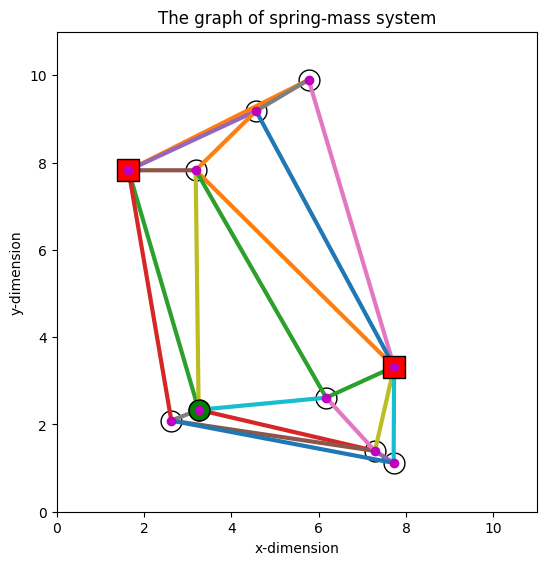

In [40]:
MARKERSIZE = 15
LINEWIDTH = 1
colored = True

fig, ax = plt.subplots()
ax.set_position([0, 0, 1, 1])
ax.set_aspect('equal')

#plotting all the points
ax.plot(net['P']['states'][:, 0], net['P']['states'][:, 1], 'o',
        markerfacecolor=[1, 1, 1], markeredgecolor='k', linewidth=LINEWIDTH, markersize=MARKERSIZE)

fixed_nodes = net['P']['states'][net['fixed_idx']]
input_nodes = net['P']['states'][net['input_idx']]
#output_nodes = net['P']['states'][net['output_idx']]

num_lines = 0
#Establishing connections

if colored:
    cmap = cm.get_cmap('jet')
    max_k = np.max(net['W']['k1'])
    min_k = np.min(net['W']['k1'])
    steepness = (64 - 1) / (max_k - min_k)
    offset = 1 - steepness * min_k

    for idx in range((net['W']['from']).shape[0]):
        #col = cmap(np.ceil(steepness * (net['W']['k1'][idx] + offset)))
        from_node = net['W']['from'][idx]
        to_node = net['W']['to'][idx]
        from_node , to_node = int(from_node), int(to_node)
        ax.plot([net['P']['states'][from_node, 0], net['P']['states'][to_node, 0]],
                [net['P']['states'][from_node, 1], net['P']['states'][to_node, 1]], linewidth=3)
        num_lines += 1
else:
    px = net['P']['states'][:, 0]
    py = net['P']['states'][:, 1]
    from_node = net['W']['from']
    to_node = net['W']['to']

    for i in range(len(net['W']['from'])):
        ax.plot([px[from_node[i]], px[to_node[i]]],
                [py[from_node[i]], py[to_node[i]]], '-k', linewidth=LINEWIDTH)

    ax.plot(net['P']['states'][:, 0], net['P']['states'][:, 1], 'o',
            markerfacecolor=[1, 1, 1], markeredgecolor='k', linewidth=LINEWIDTH, markersize=MARKERSIZE)

ax.plot(net['P']['states'][net['fixed_idx'], 0], net['P']['states'][net['fixed_idx'], 1], 's',
        markerfacecolor='r', markeredgecolor='k', linewidth=LINEWIDTH, markersize=MARKERSIZE + 1)

ax.plot(net['P']['states'][net['input_idx'], 0], net['P']['states'][net['input_idx'], 1], 'o',
        markerfacecolor='g', markeredgecolor='k', linewidth=LINEWIDTH, markersize=MARKERSIZE)

if net['readout_type'] == 'POSITIONS':
    ax.plot(net['P']['states'][net['output_idx'], 0], net['P']['states'][net['output_idx'], 1], 'om', linewidth=10)


if np.max(np.abs(net['W_fb'])) > 0 and net['W_fb'].shape[1] == 2:
    feedback_1_idx = np.setdiff1d(np.where(np.abs(net['W_fb'][:, 0]) > 0), net['fixed_idx'])
    feedback_2_idx = np.setdiff1d(np.where(np.abs(net['W_fb'][:, 1]) > 0), net['fixed_idx'])
    fb_color_1 = [0, 1, 1]
    fb_color_2 = [1, 0, 1]

    ax.plot(net['P']['states'][feedback_1_idx, 0], net['P']['states'][feedback_1_idx, 1], 'o',
            markerfacecolor=fb_color_1, markeredgecolor='k', linewidth=LINEWIDTH, markersize=MARKERSIZE)

    ax.plot(net['P']['states'][feedback_2_idx, 0], net['P']['states'][feedback_2_idx, 1], 'o',
            markerfacecolor=fb_color_2, markeredgecolor='k', linewidth=LINEWIDTH, markersize=MARKERSIZE)


ax.set_xlim(net['init_data']['x_lim'][0] * (1 - 0.1), net['init_data']['x_lim'][1] * (1 + 0.1))
ax.set_ylim(net['init_data']['y_lim'][0] * (1 - 0.1), net['init_data']['y_lim'][1] * (1 + 0.1))

ax.set_xlabel('x-dimension')
ax.set_ylabel('y-dimension')
ax.set_title('The graph of spring-mass system')
plt.show()

This is an alternative way to plot the graph

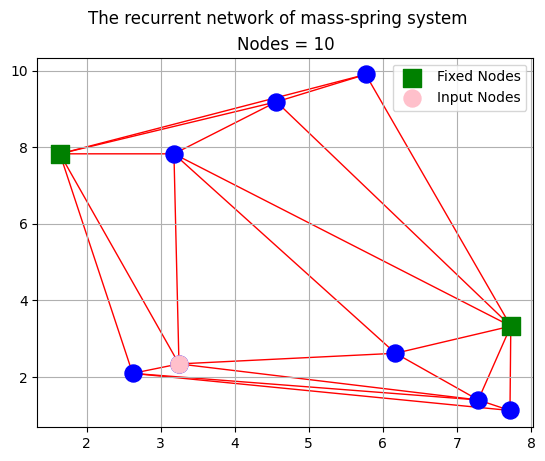

In [41]:
def plot_graph_clear(net):
  positions = net['init_data']['positions'] #get all the positions
  triangulation = net['init_data']['tri'] #getting the delauanay triangulation
  input_nodes = positions[net['input_idx']]
  nodes = net['init_data']['nodes']
  # Extract edges from triangulation
  edges = set()
  for simplex in tri.simplices:
      for i in range(3):
          edge = tuple(sorted([simplex[i], simplex[(i + 1) % 3]]))
          edges.add(edge)

  # Calculate number of non-crossing spring connections

  Li = []
  for i in edges:
    Li.append(i)
  Li = np.array(Li)
  L = Li.shape[0]

  # Plot nodes and edges
  plt.scatter(positions[:, 0], positions[:, 1], color='blue', zorder=2, s=150)
  for edge in edges:
      plt.plot(positions[edge, 0], positions[edge, 1], color='red', zorder=1, linewidth=1)

  # Highlight fixed nodes
  plt.scatter(fixed_nodes[:, 0], fixed_nodes[:, 1], marker='s', color='green', zorder=2, label='Fixed Nodes', s=150)
  plt.scatter(input_nodes[:, 0], input_nodes[:, 1], marker='o', color='pink', zorder=3, label='Input Nodes', s=150)
  plt.suptitle("The recurrent network of mass-spring system")
  plt.title(f'Nodes = {nodes}')
  ax.set_xlim(net['init_data']['x_lim'][0] * (1 - 0.1), net['init_data']['x_lim'][1] * (1 + 0.1))
  ax.set_ylim(net['init_data']['y_lim'][0] * (1 - 0.1), net['init_data']['y_lim'][1] * (1 + 0.1))
  ax.set_xlabel('x-dimension')
  ax.set_ylabel('y-dimension')
  plt.legend()
  plt.grid(True)
  plt.show()

plot_graph_clear(net)

Please note that since points are randomly choosen so the net differs in each runtime

### *4.1.2* Simulating mass spring networks

#### Before simulating we need to define few of the functions, which will be used in simulations

Let us define a function to calculate 4th Order Runge-Kutta Method for calculating new position and velocity.

**Parameters**:

func (function): name of external function to evaluate the RHS of the ODE<br>
a (float): lower limit of integration<br>
b (float): upper limit of integration<br>
x0 (float): initial condition (position)<br>
xd0 (float): initial condition (velocity)<br>
h (float): step size<br>
F (float): external force<br>

**Returns**:

t (numpy array): solution vectors of time<br>
x (numpy array): solution vectors of position<br>
v (numpy array): solution vectors of velocity<br>





In [42]:
def rk4ode2(a, b, x0, xd0, h, F):
    # Initialize arrays to store solutions
    m = 1
    x_list = [x0]
    v_list = [xd0]
    t = [a]
    i = 0
    dt = h
    i = 0
    while t[i] < b:
      v = v_list[i]
      x = x_list[i]

      k1_v = dt * (F / m)
      k1_x = dt * v

      k2_v = dt * (F / m)
      k2_x = dt * (v + 0.5 * k1_v)

      k3_v = dt * (F / m)
      k3_x = dt * (v + 0.5 * k2_v)

      k4_v = dt * (F / m)
      k4_x = dt * (v + k3_v)

      new_v = v + (1/6) * (k1_v + 2*k2_v + 2*k3_v + k4_v)
      new_x = x + (1/6) * (k1_x + 2*k2_x + 2*k3_x + k4_x)

      v_list.append(new_v)
      x_list.append(new_x)
      t.append(t[i] + dt)
      i += 1

    return np.array(t), np.array(x), np.array(v)

and the function to be used in RK40DE, we define mass as 1

Defining nonlinear spring damper function adapted for 2D.

    Parameters:
    - time_step: time step
    - x: state vector [x, y, x_dot, y_dot]
    - u: input vector [u1, u2]

    Returns:
    - x_new: updated state vector

In [43]:
def ode_simple_ms_sys(time_step, x, u):
    x_new = [0, 0, 0, 0]
    # First system x-dimension
    x_new[0] = time_step * x[2] + x[0]
    x_new[2] = x[2] + time_step * u[0]

    # Second system y-dimension
    x_new[1] = time_step * x[3] + x[1]
    x_new[3] = x[3] + time_step * u[1]

    return x_new


#### Now, we can define the simulation code to simulate our system

Let us first print the net dictionary to get all keys and values printed

In [44]:
net

{'init_data': {'nodes': 10,
  'x_lim': [0, 10],
  'y_lim': [0, 10],
  'pos_noise': 0,
  'dist_nosie': 0,
  'positions': array([[1.64057602, 7.82511936, 0.        , 0.        ],
         [5.7688529 , 9.89813879, 0.        , 0.        ],
         [7.72807312, 3.32195491, 0.        , 0.        ],
         [7.28848311, 1.39397376, 0.        , 0.        ],
         [3.2481578 , 2.33557449, 0.        , 0.        ],
         [7.71703185, 1.1188429 , 0.        , 0.        ],
         [2.62223651, 2.08853642, 0.        , 0.        ],
         [4.56441765, 9.18406687, 0.        , 0.        ],
         [3.18033113, 7.82469007, 0.        , 0.        ],
         [6.17102473, 2.61347535, 0.        , 0.        ]]),
  'fixed_positions': True,
  'k_range': array([[  1, 200],
         [  1,  10]]),
  'd_range': array([[  1, 200],
         [  1,  10]]),
  'w_out_range': [-1, 1],
  'w_feedback_range': [-1, 1],
  'w_input_range': [-1, 1],
  'fb_conn': 0,
  'nInput': 1,
  'input_percentage': 0.1,
  'nOutput

A function to generate sine wave input

In [45]:
def generate_sine_wave(net, factor=1,length=10000):
    """
    Generate a sine wave array of the same shape as the input array used for the step response with factor 1.

    Args:
    - net: network structure containing information about the number of inputs
    - factor: multiplicative factor for the sine wave amplitude

    Returns:
    - sine_wave_array: array containing sine wave data
    """
    len_data = length  # Default length of the sine wave array
    num_inputs = net['W_in'].shape[1]  # Number of input signals

    t = np.arange(len_data)
    sine_wave_array = (np.sin(t * (2 * np.pi / len_data)) * factor).reshape(len_data, 1) * np.ones((len_data, num_inputs))

    return sine_wave_array


So, we will create a function that does the simulation

In [46]:
def simulate_ms_sys(net,input_matrix,output=None):

  in_idx = np.where(net['W_in'] != 0)[0]

  if not output == None:
    TEACHER_FORCING = True
  else:
     TEACHER_FORCING = False

  if 'rk_steps' in net:
    print('We will use 4th Order Runge-Kutta method')

  P = net['P'] #points information
  W = net['W']  #connections information

  time_step = net['init_data']['time_step']
  show_steps = net['init_data']['show_steps']

  #getting number of nodes
  num = net['init_data']['nodes']

  #getting number of inputs
  input = input_matrix
  len_i = input_matrix.shape[0]

  #say input has 10 inputs, so total simulation time = 10*a = 10a seconds
  sim_time = len_i*time_step


  #let us define the simulation matrix
  data_matrix = np.zeros((len_i,num)) #each row-> each input signal, each col->each output

  sim_data = dict()

  sim_data['Fx'] = np.zeros((len_i,num)) #forces in x-dimension
  sim_data['Fy'] = np.zeros((len_i,num)) #forces in y-dimension
  sim_data['Sx'] = np.zeros((len_i,num)) #length in simulation in x-dimension
  sim_data['Sy'] = np.zeros((len_i,num)) #length in simulation in y-dimension
  sim_data['Sxd'] = np.zeros((len_i,num)) #velocity in simulation in x-dimension
  sim_data['Syd'] = np.zeros((len_i,num)) #velocity in simulation in y-dimension
  sim_data['Sx_off'] = np.zeros((len_i,num)) #the offset in matrix

  #initializing the forces and distances
  sim_data['Sx'][0] = P['states'][:,0] #the initial x-distances in first row
  sim_data['Sy'][0] = P['states'][:,1] #the initial y-distances in first row
  sim_data['Sxd'][0] = P['states'][:,2] #the initial x-velocity
  sim_data['Syd'][0] = P['states'][:,3] #the initial y-velocity

  #setting up output matrix
  sim_data['O'] = np.zeros((len_i,W['k1'].shape[0]))

  #the internal state will be either Sx or D depending upon the readout we want

  sim_data['D'] = np.zeros((len_i,W['k1'].shape[0]))

  for idx in range(len_i): #go through each input signal
    i = idx
    print(f'i = {idx} of {sim_time/time_step}') #print each iteration

    P['force'][:,:2] = np.zeros((num,2)) #set all old forces to be zero

    #so, now we go through all connections and calculate force

    for c in range(int(W['k1'].shape[0])):
      #get actual points connected by spring
      fr = int(W['from'][c])
      to = int(W['to'][c])

      #get the distance between point
      p_from = np.array([ P['states'][fr][0], P['states'][fr][1] ])
      p_to = np.array([ P['states'][to][0], P['states'][to][1] ])

      d,ndir = e_distance(p_from, p_to)

      if net['readout_type'] == 'LENGTHS':
        sim_data['D'][idx,c] = d #setting the distance for each input row and spring column

      del_d = d - W['l0'][c]
      del_old_d = (d - W['dist_old'][c])/time_step

      #getting force amplitude
      if 'tansig' in net:

        A_k = W['k1'][c]
        k_k = W['k3'][c]
        A_d = W['d1'][c]
        k_d = W['d3'][c]
        if net['tansig'] == 1:
          Fk = -1 + (2*A_k)/(1 + np.exp(-2*abs(k_k)*(del_d))) + del_d
          Fd = -1 + (2*A_d)/(1+ np.exp(-2*abs(k_d)*(del_old_d))) + del_old_d
        else:
          Fk = -1 + (2*A_k)/(1 + np.exp(-2 * abs(k_k) * del_d))
          Fd = -1 + (2*A_d)/(1 + np.exp(-2 * abs(k_d) * del_old_d))
      else:
        #if not tansig springs, so we have non-linear force amplitude
        Fk = W['k3'][c] * (del_d**3) + W['k1'][c] * (del_d) #force by spring
        Fd = W['d3'][c] * (del_old_d**3) + W['d1'][c] * (del_old_d) #force by damping
        #print(f'delOld = {del_old_d}, {del_old_d**3},Fk = {Fk},Fd = {Fd}')
      #now we need to add forces at not-fixed nodes. Because as the fixed nodes, dont move, so their force will be kept 0 only as all force will be absorbed by the walls

      if(int(P['fixed'][to]) == 0):
        P['force'][to][0] += (-1)*(Fk+Fd)*ndir[0] #fx
        P['force'][to][1] += (-1)*(Fk+Fd)*ndir[1] #fy

      if(int(P['fixed'][fr]) == 0):
        P['force'][fr][0] += (Fk+Fd)*ndir[0] #Fx it puts
        P['force'][to][1] += (Fk+Fd)*ndir[1] #Fy it puts

      sim_data['Fx'][idx,to] = P['force'][to][0]
      sim_data['Fy'][idx,to] = P['force'][to][1]

      sim_data['Fx'][idx,fr] = P['force'][fr][0]
      sim_data['Fy'][idx,fr] = P['force'][fr][1]

      #now, we update the old distance with actual distance
      W['dist_old'][c] = d

    #Now, we have went through all connections and added the force

    #So, now we add input signals as Fx
    #print(P['force'][:,0], sim_data['O'][idx])
    #print(P['force'][:,0].shape,sim_data['O'][idx].shape)
    #print(np.dot(net['W_fb'],sim_data['O'][idx].T).shape)

    if idx == 0:
      P['force'][:,0] = P['force'][:,0] + np.dot(net['W_in'], input_matrix[idx,:]) #+ np.dot(net['W_fb'],sim_data['O'][idx])
    else:
      P['force'][:,0] = P['force'][:,0] + np.dot(net['W_in'], input_matrix[idx,:]) #+ np.dot(net['W_fb'],sim_data['O'][idx-1])

    #Now let us put forces = 0 and velocity = 0 for all fixed points
    fix_idx = net['fixed_idx']
    for fixed_index in fix_idx:
      P['states'][fixed_index][2:4] = np.zeros((2,))
      P['force'][fixed_index][0:2] = np.zeros((2,))


    ##Now we simulate all dynamic mass-node system

    for i in range(P['states'].shape[0]):

      #if there are no rk_steps defined, so we go with Euler integration

      if not 'rk_steps' in net:
        xnew = ode_simple_ms_sys(time_step,P['states'][i,0:4],P['force'][i,0:2])
        P['states'][i,:] = xnew
      else:
      ##Now we
        tx,xx,vx = rk4ode2(a=0,b=time_step,x0=P['states'][i,0],xd0=P['states'][i,2],h=time_step/net['rk_steps'],F=P['force'][i,0])
        ty,xy,vy = rk4ode2(a=0,b=time_step,x0=P['states'][i,1],xd0=P['states'][i,3],h=time_step/net['rk_steps'],F=P['force'][i,0])

        #now updating the states
        P['states'][i,0] = xx
        P['states'][i,1] = xy
        P['states'][i,2] = vx
        P['states'][i,3] = vy
      #ended the rk_steps if conditions

      #saving the sim data
      sim_data['Sx'][idx,i] = P['states'][i,0]
      sim_data['Sy'][idx,i] = P['states'][i,1]
      sim_data['Sxd'][idx,i] = P['states'][i,2]
      sim_data['Syd'][idx,i] = P['states'][i,3]

      if net['readout_type'] == 'Positions':
        sim_data['Sx'][idx,i] = P['states'][i,0]

    #end the simulation loop

    if net['readout_type'] == 'POSITIONS':
      sim_data['O'][idx] = np.dot(net['W_out'].T, P['states'][:,1])
    if net['readout_type'] == 'LENGTHS':
      sim_data['O'][idx] = np.dot(net['W_out'].T, sim_data['D'][idx])

    if np.count_nonzero(np.isnan(sim_data['O'][idx])) > 0:
      sim_data['Error'] = 'NaN - Error / Unstable simulation'
      print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
      print('!!!!! NaN - Error / Un-stable Simulation !!!!!')
      print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
      net_after = 0
      return net_after, sim_data

  net_after = net.copy()
  net_after['P'] = P
  net_after['W'] = W

  return net_after, sim_data
  #print(sim_data)


A function to show step response

    Parameters:
    - net: net structure
    - len: number of data points to simulate
    - factor: multiplicative factor for the constant input
              factor = 1: step response
              factor = 0: input is IMPULSE response
    - show_plot: showing plots of the result (optional), default is True
    - inputC: defines the input

    Returns:
    - sim_data: simulation data

In [47]:
def step_response(net, length=10000, factor=1, show_plot=True,inputC=None):
    netk = net.copy()
    if inputC==None:
      input_factor_0 = np.vstack( (np.ones( ( net['W_in'].shape[1], ) ) , np.zeros( ( length - 1, net['W_in'].shape[1] ) ) ) )
      input = factor * np.ones((length, net['W_in'].shape[1]))
    if inputC=='sin':
      input = input_factor_0 = generate_sine_wave(net,factor=factor,length=length)
    if factor == 0:
      print('Reading out impulse response')
      net_1, sim_data = simulate_ms_sys(net, input_factor_0)
    else:
      print(f'Reading out non-zero factor response')
      net_1, sim_data = simulate_ms_sys(net,input)
    if show_plot:
      print('Plotting the graph')
      print(sim_data['O'])
      plt.plot(sim_data['O'])
      plt.show()

    return net_1,sim_data,netk


So, we have two types of position determination,
  - Runge Kutta Method
  - Ordinary differential equation

## Response

### Sin Input

#### Runge Kutta Method

Streaming output truncated to the last 5000 lines.
i = 5008 of 10000.0
i = 5009 of 10000.0
i = 5010 of 10000.0
i = 5011 of 10000.0
i = 5012 of 10000.0
i = 5013 of 10000.0
i = 5014 of 10000.0
i = 5015 of 10000.0
i = 5016 of 10000.0
i = 5017 of 10000.0
i = 5018 of 10000.0
i = 5019 of 10000.0
i = 5020 of 10000.0
i = 5021 of 10000.0
i = 5022 of 10000.0
i = 5023 of 10000.0
i = 5024 of 10000.0
i = 5025 of 10000.0
i = 5026 of 10000.0
i = 5027 of 10000.0
i = 5028 of 10000.0
i = 5029 of 10000.0
i = 5030 of 10000.0
i = 5031 of 10000.0
i = 5032 of 10000.0
i = 5033 of 10000.0
i = 5034 of 10000.0
i = 5035 of 10000.0
i = 5036 of 10000.0
i = 5037 of 10000.0
i = 5038 of 10000.0
i = 5039 of 10000.0
i = 5040 of 10000.0
i = 5041 of 10000.0
i = 5042 of 10000.0
i = 5043 of 10000.0
i = 5044 of 10000.0
i = 5045 of 10000.0
i = 5046 of 10000.0
i = 5047 of 10000.0
i = 5048 of 10000.0
i = 5049 of 10000.0
i = 5050 of 10000.0
i = 5051 of 10000.0
i = 5052 of 10000.0
i = 5053 of 10000.0
i = 5054 of 10000.0
i = 5055 

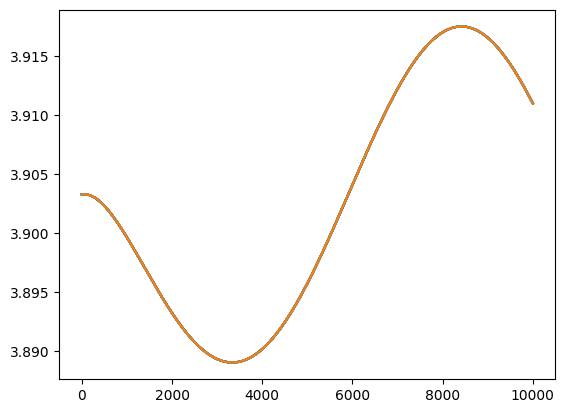

In [48]:
a,b,c = step_response(net,length=10000,factor=1,inputC='sin')

#### Ordinary differential equation

Streaming output truncated to the last 5000 lines.
i = 5008 of 10000.0
i = 5009 of 10000.0
i = 5010 of 10000.0
i = 5011 of 10000.0
i = 5012 of 10000.0
i = 5013 of 10000.0
i = 5014 of 10000.0
i = 5015 of 10000.0
i = 5016 of 10000.0
i = 5017 of 10000.0
i = 5018 of 10000.0
i = 5019 of 10000.0
i = 5020 of 10000.0
i = 5021 of 10000.0
i = 5022 of 10000.0
i = 5023 of 10000.0
i = 5024 of 10000.0
i = 5025 of 10000.0
i = 5026 of 10000.0
i = 5027 of 10000.0
i = 5028 of 10000.0
i = 5029 of 10000.0
i = 5030 of 10000.0
i = 5031 of 10000.0
i = 5032 of 10000.0
i = 5033 of 10000.0
i = 5034 of 10000.0
i = 5035 of 10000.0
i = 5036 of 10000.0
i = 5037 of 10000.0
i = 5038 of 10000.0
i = 5039 of 10000.0
i = 5040 of 10000.0
i = 5041 of 10000.0
i = 5042 of 10000.0
i = 5043 of 10000.0
i = 5044 of 10000.0
i = 5045 of 10000.0
i = 5046 of 10000.0
i = 5047 of 10000.0
i = 5048 of 10000.0
i = 5049 of 10000.0
i = 5050 of 10000.0
i = 5051 of 10000.0
i = 5052 of 10000.0
i = 5053 of 10000.0
i = 5054 of 10000.0
i = 5055 

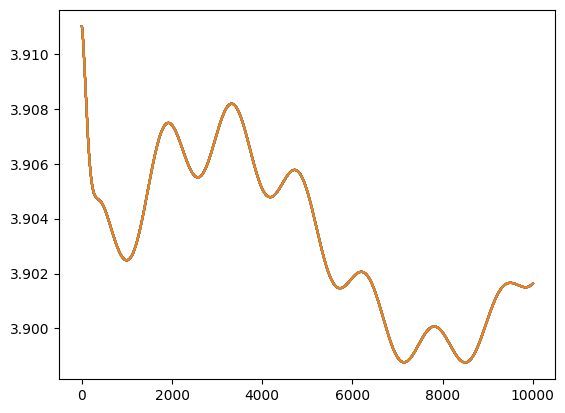

In [49]:
del net['rk_steps']

a,b,c = step_response(net,length=10000,factor=1,inputC='sin')

### Uniform input of 5 units

#### Ordinary differential equation


Streaming output truncated to the last 5000 lines.
i = 5008 of 10000.0
i = 5009 of 10000.0
i = 5010 of 10000.0
i = 5011 of 10000.0
i = 5012 of 10000.0
i = 5013 of 10000.0
i = 5014 of 10000.0
i = 5015 of 10000.0
i = 5016 of 10000.0
i = 5017 of 10000.0
i = 5018 of 10000.0
i = 5019 of 10000.0
i = 5020 of 10000.0
i = 5021 of 10000.0
i = 5022 of 10000.0
i = 5023 of 10000.0
i = 5024 of 10000.0
i = 5025 of 10000.0
i = 5026 of 10000.0
i = 5027 of 10000.0
i = 5028 of 10000.0
i = 5029 of 10000.0
i = 5030 of 10000.0
i = 5031 of 10000.0
i = 5032 of 10000.0
i = 5033 of 10000.0
i = 5034 of 10000.0
i = 5035 of 10000.0
i = 5036 of 10000.0
i = 5037 of 10000.0
i = 5038 of 10000.0
i = 5039 of 10000.0
i = 5040 of 10000.0
i = 5041 of 10000.0
i = 5042 of 10000.0
i = 5043 of 10000.0
i = 5044 of 10000.0
i = 5045 of 10000.0
i = 5046 of 10000.0
i = 5047 of 10000.0
i = 5048 of 10000.0
i = 5049 of 10000.0
i = 5050 of 10000.0
i = 5051 of 10000.0
i = 5052 of 10000.0
i = 5053 of 10000.0
i = 5054 of 10000.0
i = 5055 

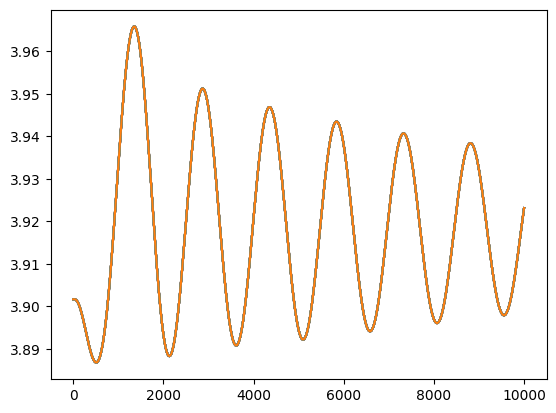

In [50]:
a,b,c = step_response(net,length=10000,factor=5)

#### Runge Kutta Method

Streaming output truncated to the last 5000 lines.
i = 5008 of 10000.0
i = 5009 of 10000.0
i = 5010 of 10000.0
i = 5011 of 10000.0
i = 5012 of 10000.0
i = 5013 of 10000.0
i = 5014 of 10000.0
i = 5015 of 10000.0
i = 5016 of 10000.0
i = 5017 of 10000.0
i = 5018 of 10000.0
i = 5019 of 10000.0
i = 5020 of 10000.0
i = 5021 of 10000.0
i = 5022 of 10000.0
i = 5023 of 10000.0
i = 5024 of 10000.0
i = 5025 of 10000.0
i = 5026 of 10000.0
i = 5027 of 10000.0
i = 5028 of 10000.0
i = 5029 of 10000.0
i = 5030 of 10000.0
i = 5031 of 10000.0
i = 5032 of 10000.0
i = 5033 of 10000.0
i = 5034 of 10000.0
i = 5035 of 10000.0
i = 5036 of 10000.0
i = 5037 of 10000.0
i = 5038 of 10000.0
i = 5039 of 10000.0
i = 5040 of 10000.0
i = 5041 of 10000.0
i = 5042 of 10000.0
i = 5043 of 10000.0
i = 5044 of 10000.0
i = 5045 of 10000.0
i = 5046 of 10000.0
i = 5047 of 10000.0
i = 5048 of 10000.0
i = 5049 of 10000.0
i = 5050 of 10000.0
i = 5051 of 10000.0
i = 5052 of 10000.0
i = 5053 of 10000.0
i = 5054 of 10000.0
i = 5055 

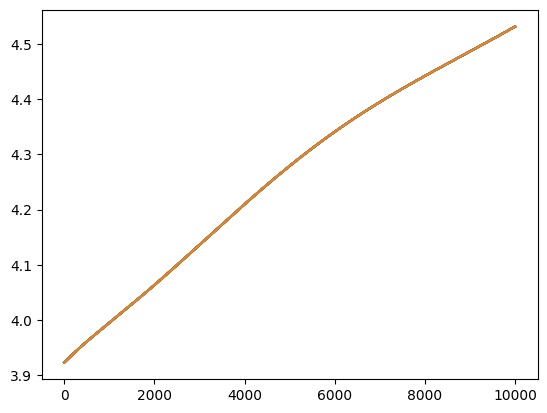

In [51]:
net['rk_steps'] = 100

a,b,c = step_response(net,length=10000,factor=5)

### Impulsive response

Reading out impulse response
We will use 4th Order Runge-Kutta method
i = 0 of 10000.0
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!! NaN - Error / Un-stable Simulation !!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Plotting the graph
[[nan nan nan ... nan nan nan]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


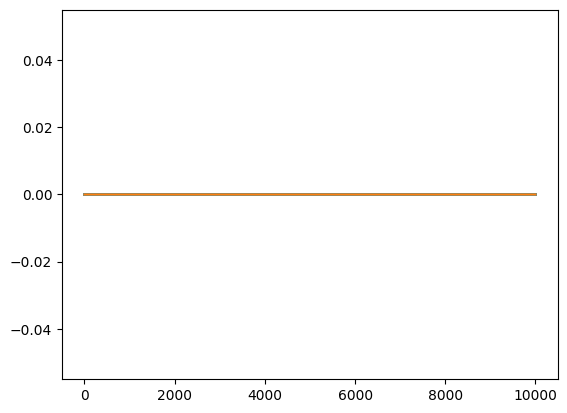

In [55]:
a,b,c = step_response(net,length=10000,factor=0)

##  Notes

The graphs can be obtained using changing the parameters in simulation